In [1]:
LLM_list = ['llama3', 'phi3', 'mistral']

In [2]:
import dspy
import sys
import argparse
import json
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from hybridagi import GraphProgramInterpreter
from hybridagi import SentenceTransformerEmbeddings
from hybridagi import ProgramMemory, TraceMemory, FileSystem, AgentState
from hybridagi.tools import (
    DuckDuckGoSearchTool,
    ProgramSearchTool,
    DocumentSearchTool,
    CallProgramTool,
    PredictTool,
    InternalShellTool,
    WriteFileTool,
    AppendFileTool,
    ReadFileTool,
    SpeakTool,
    AskUserTool,
    UpdateObjectiveTool,
    UploadTool,
    ClearTraceTool,
    PastActionSearchTool,
    #PlannifyProgramTool,
    #ChainOfThoughtTool,
    #ProgramOfThoughtTool,
    ReadProgramTool,
    RevertTraceTool,
    WriteProgramTool,
)
from pydantic import BaseModel
from dspy.teleprompt import BootstrapFewShotWithRandomSearch


class AssessAnswer(dspy.Signature):
    """Assess the success of the trace according to the objective"""
    assessed_answer = dspy.InputField(desc="The answer to assess")
    assessed_question = dspy.InputField(desc="The question to be assessed")
    critique = dspy.OutputField(desc="The critique of the answer")

class Score(BaseModel):
    score: float

class CritiqueToScoreSignature(dspy.Signature):
    """Convert a critique into a score between 0.0 and 1.0"""
    critique = dspy.InputField(desc="The critique to convert into a score")
    score: Score = dspy.OutputField(desc="A score between 0.0 and 1.0")

def case_setup(example_index, embeddings):

    #print("Initializing the program memory...")
    program_memory = ProgramMemory(
        index_name = example_index,
        embeddings = embeddings,
        wipe_on_start = True,
    )

    #print("Initializing the trace memory...")
    trace_memory = TraceMemory(
        index_name = example_index,
        embeddings = embeddings,
        wipe_on_start = True,
    )

    #print("Initializing the internal filesystem...")
    filesystem = FileSystem(
        index_name = example_index,
        embeddings = embeddings,
    )
    
    agent_state = AgentState()

    tools = [
        DuckDuckGoSearchTool(),
        PredictTool(),
        ProgramSearchTool(
            program_memory = program_memory,
            embeddings = embeddings,
        ),
        DocumentSearchTool(
            filesystem = filesystem,
            embeddings = embeddings,
        ),
        CallProgramTool(
            program_memory = program_memory,
            agent_state = agent_state,
        ),
        InternalShellTool(
            filesystem = filesystem,
            agent_state = agent_state,
        ),
        WriteFileTool(
            filesystem = filesystem,
            agent_state = agent_state,
        ),
        AppendFileTool(
            filesystem = filesystem,
            agent_state = agent_state,
        ),
        ReadFileTool(
            filesystem = filesystem,
            agent_state = agent_state,
        ),
        UploadTool(
            filesystem = filesystem,
            agent_state = agent_state,
        ),
        SpeakTool(
            agent_state = agent_state,
        ),
        AskUserTool(
            agent_state = agent_state,
        ),
        UpdateObjectiveTool(
            agent_state=agent_state
        ),
        UploadTool(
            filesystem=filesystem,
            agent_state=agent_state
        ),
        ClearTraceTool(
            agent_state=agent_state
        ),
        PastActionSearchTool(
            trace_memory=trace_memory,
            embeddings=embeddings
        ),
        InternalShellTool(
            filesystem=filesystem,
            agent_state=agent_state
        ),
        ReadProgramTool(
            program_memory=program_memory
        ),
        RevertTraceTool(
            agent_state=agent_state
        ),
        WriteProgramTool(
            program_memory=program_memory
        )
    ]

    program_memory.add_folders(["examples/primitives", "examples/"+example_index+"/programs"])

    interpreter = GraphProgramInterpreter(
                program_memory = program_memory,
                trace_memory = trace_memory,
                agent_state = agent_state,
                tools = tools,
            )

    return program_memory, trace_memory, filesystem, agent_state, tools, interpreter

/home/timothee/anaconda3/envs/hybridagi/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def evaluate_model(model_name, examples, embeddings):
    student_llm = dspy.OllamaLocal(model=model_name, max_tokens=1024, stop=["\n\n\n", "\n\n---\n", "<|eot_id|>"])
    teacher_llm = dspy.OllamaLocal(model='mistral', max_tokens=1024, stop=["\n\n\n", "\n\n---\n", "<|eot_id|>"])

    dspy.settings.configure(lm=student_llm)

    def program_success(example, pred, trace=None):
            question = example.objective
            with dspy.context(lm=teacher_llm):
                prediction = dspy.ChainOfThought(AssessAnswer)(
                    assessed_answer = pred.final_answer,
                    assessed_question = question,
                )
                result = dspy.TypedPredictor(CritiqueToScoreSignature)(critique=prediction.critique)
            return result.score.score
    
    """ optimizer = BootstrapFewShotWithRandomSearch(
        num_threads = 1,
        teacher_settings=dict({'lm': teacher_llm}),
        metric = program_success,
        **config,
    ) """

    scores = []

    for example_index in examples:
        print("EXAMPLE ", example_index)
        program_memory, trace_memory, filesystem, agent_state, tools, interpreter = case_setup(example_index, embeddings)
        with open("examples/"+example_index+"/objectives.json", 'r') as objectives_f:
            objectives = json.load(objectives_f)
        dataset, testset = objectives["dataset"], objectives["testset"]

        """ compiled_interpreter = optimizer.compile(
            interpreter,
            trainset=[dspy.Example(objective).with_inputs("objective") for objective in dataset],
            valset=testset,
        ) """

        evaluate = dspy.evaluate.Evaluate(
            devset = [dspy.Example(objective).with_inputs("objective") for objective in testset],
            metric = program_success,
            num_threads = 1,
            display_progress = False,
            display_table = 0,
        )
        try:
            baseline_score = evaluate(interpreter)
        except Exception:
            baseline_score = 0.0
        
        scores.append(baseline_score)
    
    print(scores)
    print(f"{model_name} achieved average score of {np.mean(scores)}")
    return scores

In [6]:
embeddings = SentenceTransformerEmbeddings(dim=384, model_name_or_path="sentence-transformers/all-MiniLM-L6-v2")

examples = [example for example in os.listdir("examples") if os.path.isdir(os.path.join("examples", example)) and example != 'primitives']

config = dict(max_bootstrapped_demos=4, max_labeled_demos=4)

models_scores = {}

for model_name in tqdm(LLM_list):
    scores = evaluate_model(model_name, examples, embeddings)
    models_scores[model_name] = scores

results = pd.DataFrame(models_scores.values(), columns=examples, index=models_scores.keys())
results["average"] = results.mean(axis=1)
print(results)

  0%|          | 0/3 [00:00<?, ?it/s]

EXAMPLE  rag_with_optional_websearch
 --- Step 0 ---
Call Program: main
Program Purpose: What is the tallest mountain in the world?
 --- Step 1 ---
Decision Purpose: Check if searching for information online is needed to answer the objectve's question
Decision Question: Is searching online needed to answer the objective's question?
Decision: YES


2024-05-14 12:31:34,131 ERROR dspy.evaluate.evaluate: 2024-05-14T10:31:34.131347Z [error    ] Error for example in dev set: 		 https://links.duckduckgo.com/d.js?q=tallest+mountain&kl=wt-wt&l=wt-wt&p=&s=0&df=&vqd=4-165224340291741097053869926448603428323&ex=-1 202 Ratelimit [dspy.evaluate.evaluate] filename=evaluate.py lineno=147


 --- Step 0 ---
Call Program: main
Program Purpose: Who is the richest person in the world currently?
 --- Step 1 ---
Decision Purpose: Check if searching for information online is needed to answer the objectve's question
Decision Question: Is searching online needed to answer the objective's question?
Decision: YES


2024-05-14 12:31:38,851 ERROR dspy.evaluate.evaluate: 2024-05-14T10:31:38.851559Z [error    ] Error for example in dev set: 		 https://links.duckduckgo.com/d.js?q=richest+person+in+world&kl=wt-wt&l=wt-wt&p=&s=0&df=&vqd=4-75935604395690993225453130544262563615&ex=-1 202 Ratelimit [dspy.evaluate.evaluate] filename=evaluate.py lineno=147


 --- Step 0 ---
Call Program: main
Program Purpose: What is the formula for calculating the area of a circle?
 --- Step 1 ---
Decision Purpose: Check if searching for information online is needed to answer the objectve's question
Decision Question: Is searching online needed to answer the objective's question?
Decision: NO
 --- Step 2 ---
Action Purpose: Answer the objective's question
Action: {
  "answer": "The formula for calculating the area of a circle is A = \u03c0r^2, where A is the area and r is the radius."
}
 --- Step 3 ---
End Program: main
Final Answer:

The formula for calculating the area of a circle is A = πr^2, where A is the area and r is the radius.
Chat History:

[
  {
    "role": "User",
    "message": "What is the formula for calculating the area of a circle?"
  },
  {
    "role": "AI",
    "message": "The formula for calculating the area of a circle is A = \u03c0r^2, where A is the area and r is the radius."
  }
]
 --- Step 0 ---
Call Program: main
Program Purpose:

2024-05-14 12:32:00,094 ERROR dspy.evaluate.evaluate: 2024-05-14T10:32:00.094295Z [error    ] Error for example in dev set: 		 https://links.duckduckgo.com/d.js?q=COVID-19+vaccine+news&kl=wt-wt&l=wt-wt&p=&s=0&df=&vqd=4-281717376825558106724257794677085910233&ex=-1 202 Ratelimit [dspy.evaluate.evaluate] filename=evaluate.py lineno=147


 --- Step 0 ---
Call Program: main
Program Purpose: What is the chemical formula for water?


2024-05-14 12:32:03,746 ERROR dspy.primitives.assertions: 2024-05-14T10:32:03.746611Z [error    ] AssertionError: Got BASED ON THE REASONING PROVIDED, I WOULD SELECT:.

Selected Label should be only ONE of the following label: YES or MAYBE or UNKNOWN or NO [dspy.primitives.assertions] filename=assertions.py lineno=88
2024-05-14 12:32:03,747 ERROR dspy.evaluate.evaluate: 2024-05-14T10:32:03.747424Z [error    ] Error for example in dev set: 		 Got BASED ON THE REASONING PROVIDED, I WOULD SELECT:.

Selected Label should be only ONE of the following label: YES or MAYBE or UNKNOWN or NO [dspy.evaluate.evaluate] filename=evaluate.py lineno=147


EXAMPLE  rag_that_remember_actions
 --- Step 0 ---
Call Program: main
Program Purpose: Can you explain the concept of blockchain technology?
 --- Step 1 ---
Action Purpose: Search past actions to answer the objective's question
Action: {
  "query": "What is blockchain? OR How does blockchain work? OR Blockchain definition",
  "past_actions": []
}
 --- Step 2 ---
Decision Purpose: Check if the answer to the objective's question is in the above search
Decision Question: Is the answer in the context?
Decision: YES
 --- Step 3 ---
Action Purpose: Answer the objective's question based on the search
Action: {
  "message": "\"Blockchain technology is a decentralized, digital ledger that records transactions across a network of computers. It allows for secure, transparent, and tamper-proof data storage and transfer. In essence, it's a chain of blocks (hence the name) that contain information, such as financial transactions or smart contracts, which are linked together through cryptography.\""


2024-05-14 12:33:56,542 ERROR dspy.evaluate.evaluate: 2024-05-14T10:33:56.541947Z [error    ] Error for example in dev set: 		 Invalid tool: 'ContentSearch' does not exist, should be one of ['DuckDuckGoSearch', 'Predict', 'ProgramSearch', 'DocumentSearch', 'CallProgram', 'InternalShell', 'WriteFile', 'AppendFile', 'ReadFile', 'Upload', 'Speak', 'AskUser', 'UpdateObjective', 'ClearTrace', 'PastActionSearch', 'ReadProgram', 'RevertTrace', 'WriteProgram'] [dspy.evaluate.evaluate] filename=evaluate.py lineno=147


 --- Step 5 ---
Action Purpose: Pick the most appropriate routine from the previous search
Action: {
  "selected_routine": "filesystem_search",
  "observation": "Successfully called"
}
 --- Step 0 ---
Call Program: main
Program Purpose: What is a neuro-symbolic artificial intelligence?


2024-05-14 12:33:59,142 ERROR dspy.primitives.assertions: 2024-05-14T10:33:59.142830Z [error    ] AssertionError: Got OBJECTIVE: WHAT IS A NEURO-SYMBOLIC ARTIFICIAL INTELLIGENCE?.

Selected Label should be only ONE of the following label: INSTRUCTION or QUESTION [dspy.primitives.assertions] filename=assertions.py lineno=88
2024-05-14 12:33:59,144 ERROR dspy.evaluate.evaluate: 2024-05-14T10:33:59.143945Z [error    ] Error for example in dev set: 		 Got OBJECTIVE: WHAT IS A NEURO-SYMBOLIC ARTIFICIAL INTELLIGENCE?.

Selected Label should be only ONE of the following label: INSTRUCTION or QUESTION [dspy.evaluate.evaluate] filename=evaluate.py lineno=147


 --- Step 0 ---
Call Program: main
Program Purpose: Search for HybridAGI on internet
 --- Step 1 ---
Decision Purpose: Check if the objective is a question or an instruction
Decision Question: Choose between INSTRUCTION or QUESTION using the objective
Decision: QUESTION
 --- Step 2 ---
Action Purpose: Answer the objective's question
Action: {
  "answer": "Hybrid Artificial General Intelligence (HybridAGI) refers to a hypothetical AI system that combines the strengths of different AI approaches, such as rule-based systems, connectionist networks, and symbolic reasoning, to achieve human-like intelligence."
}
 --- Step 3 ---
End Program: main
Final Answer:


Chat History:

[
  {
    "role": "User",
    "message": "Search for HybridAGI on internet"
  },
  {
    "role": "AI",
    "message": ""
  }
]
 --- Step 0 ---
Call Program: main
Program Purpose: Print the current working directory
 --- Step 1 ---
Decision Purpose: Check if the objective is a question or an instruction
Decision Questio

2024-05-14 12:34:49,914 ERROR dspy.evaluate.evaluate: 2024-05-14T10:34:49.914635Z [error    ] Error for example in dev set: 		 Invalid tool: 'ContentSearch' does not exist, should be one of ['DuckDuckGoSearch', 'Predict', 'ProgramSearch', 'DocumentSearch', 'CallProgram', 'InternalShell', 'WriteFile', 'AppendFile', 'ReadFile', 'Upload', 'Speak', 'AskUser', 'UpdateObjective', 'ClearTrace', 'PastActionSearch', 'ReadProgram', 'RevertTrace', 'WriteProgram'] [dspy.evaluate.evaluate] filename=evaluate.py lineno=147


 --- Step 5 ---
Action Purpose: Pick the most appropriate routine from the previous search
Action: {
  "selected_routine": "filesystem_search",
  "observation": "Successfully called"
}
EXAMPLE  qa_multi_hop_with_critique
 --- Step 0 ---
Call Program: main
Program Purpose: What are the risks and benefits associated with the use of AI in performance evaluation and decision-making processes within organizations?
 --- Step 1 ---
Action Purpose: Answer the objective's question
Action: {
  "answer": "**Benefits:**\n\n1. **Improved accuracy**: AI-powered systems can analyze large amounts of data quickly and accurately, reducing human bias and errors.\n2. **Increased efficiency**: AI can automate routine tasks, freeing up employees to focus on higher-value work.\n3. **Enhanced decision-making**: AI-driven insights can provide organizations with data-driven recommendations for performance evaluation and decision-making.\n4. **Cost savings**: AI-powered systems can reduce the need for manual dat

2024-05-14 12:36:07,383 ERROR dspy.primitives.assertions: 2024-05-14T10:36:07.382969Z [error    ] AssertionError: Got THE SELECTED LABEL IS:.

Selected Label should be only ONE of the following label: YES or NO [dspy.primitives.assertions] filename=assertions.py lineno=88
2024-05-14 12:36:07,384 ERROR dspy.evaluate.evaluate: 2024-05-14T10:36:07.384059Z [error    ] Error for example in dev set: 		 Got THE SELECTED LABEL IS:.

Selected Label should be only ONE of the following label: YES or NO [dspy.evaluate.evaluate] filename=evaluate.py lineno=147


 --- Step 0 ---
Call Program: main
Program Purpose: What are some potential industries or professions that could be significantly affected by AI in the coming years? list 5 of them
 --- Step 1 ---
Action Purpose: Answer the objective's question
Action: {
  "answer": "1. **Healthcare Professionals**: AI-powered diagnostic tools and personalized medicine may replace some healthcare professionals' roles, such as radiologists and pathologists.\n2. **Customer Service Representatives**: Chatbots and virtual assistants could automate routine customer inquiries, reducing the need for human representatives in certain industries.\n3. **Financial Analysts**: AI-driven financial modeling and forecasting software might reduce the demand for human analysts in areas like investment banking and portfolio management.\n4. **Manufacturing Line Workers**: Automation and robotics could replace some manufacturing line workers as AI-powered machines take over repetitive tasks, such as assembly and inspection

2024-05-14 12:39:28,063 ERROR dspy.primitives.assertions: 2024-05-14T10:39:28.063103Z [error    ] AssertionError: Got BASED ON THE REASONING, I WOULD SELECT:.

Selected Label should be only ONE of the following label: NO or MAYBE or YES [dspy.primitives.assertions] filename=assertions.py lineno=88
2024-05-14 12:39:28,064 ERROR dspy.evaluate.evaluate: 2024-05-14T10:39:28.064044Z [error    ] Error for example in dev set: 		 Got BASED ON THE REASONING, I WOULD SELECT:.

Selected Label should be only ONE of the following label: NO or MAYBE or YES [dspy.evaluate.evaluate] filename=evaluate.py lineno=147


 --- Step 0 ---
Call Program: main
Program Purpose: When did the French Revolution occur?
 --- Step 1 ---
Call Program: clarify_objective
Program Purpose: Clarify the objective if needed
 --- Step 2 ---
Decision Purpose: Check if the objective is unclear
Decision Question: Is the objective still unclear?
Decision: NO
 --- Step 3 ---
End Program: clarify_objective
 --- Step 4 ---
Action Purpose: Answer the objective's question
Action: {
  "message": "The French Revolution occurred from 1789 to 1799."
}
 --- Step 5 ---
End Program: main
Final Answer:

Based on the provided format, here is the output
Chat History:

[
  {
    "role": "User",
    "message": "When did the French Revolution occur?"
  },
  {
    "role": "AI",
    "message": "The French Revolution occurred from 1789 to 1799."
  },
  {
    "role": "AI",
    "message": "Based on the provided format, here is the output"
  }
]
 --- Step 0 ---
Call Program: main
Program Purpose: How can I be happy?
 --- Step 1 ---
Call Program: clar

2024-05-14 12:41:55,631 ERROR dspy.primitives.assertions: 2024-05-14T10:41:55.631113Z [error    ] AssertionError: Got THE SELECTED LABEL IS:.

Selected Label should be only ONE of the following label: NO or YES [dspy.primitives.assertions] filename=assertions.py lineno=88
2024-05-14 12:41:55,631 ERROR dspy.evaluate.evaluate: 2024-05-14T10:41:55.631762Z [error    ] Error for example in dev set: 		 Got THE SELECTED LABEL IS:.

Selected Label should be only ONE of the following label: NO or YES [dspy.evaluate.evaluate] filename=evaluate.py lineno=147


EXAMPLE  qa_simple
 --- Step 0 ---
Call Program: main
Program Purpose: What are the risks and benefits associated with the use of AI in performance evaluation and decision-making processes within organizations?
 --- Step 1 ---
Action Purpose: Answer the objective's question
Action: {
  "answer": "**Benefits:**\n\n1. **Improved accuracy**: AI can analyze large amounts of data quickly and accurately, reducing human bias and errors.\n2. **Increased efficiency**: AI can automate routine tasks, freeing up employees to focus on higher-value work.\n3. **Enhanced decision-making**: AI can provide insights and recommendations based on data-driven analysis, supporting informed decision-making.\n4. **Faster feedback**: AI can provide immediate feedback and coaching, enabling employees to adjust their performance quickly.\n\n**Risks:**\n\n1. **Job displacement**: AI may automate tasks currently performed by humans, potentially displacing certain jobs.\n2. **Biased decision-making**: AI systems can

 33%|███▎      | 1/3 [12:14<24:29, 734.87s/it]

[20.0, 72.0, 35.0, 50.0, 78.0, 40.0, 67.0, 88.0]
llama3 achieved average score of 56.25
EXAMPLE  rag_with_optional_websearch
 --- Step 0 ---
Call Program: main
Program Purpose: What is the tallest mountain in the world?
 --- Step 1 ---
Decision Purpose: Check if searching for information online is needed to answer the objectve's question
Decision Question: Is searching online needed to answer the objective's question?
Decision: MAYBE


2024-05-14 12:44:06,316 ERROR dspy.evaluate.evaluate: 2024-05-14T10:44:06.316569Z [error    ] Error for example in dev set: 		 https://links.duckduckgo.com/d.js?q=tallest+mountain%3C%7Cend%7C%3E%3C%7Cassistant%7C%3E+Objective%3A+Identify+the+tallest+mountain+on+Earth.&kl=wt-wt&l=wt-wt&p=&s=0&df=&vqd=4-207655026090318171998063702089506152157&ex=-1 202 Ratelimit [dspy.evaluate.evaluate] filename=evaluate.py lineno=147


 --- Step 0 ---
Call Program: main
Program Purpose: Who is the richest person in the world currently?
 --- Step 1 ---
Decision Purpose: Check if searching for information online is needed to answer the objectve's question
Decision Question: Is searching online needed to answer the objective's question?
Decision: YES


2024-05-14 12:44:09,689 ERROR dspy.evaluate.evaluate: 2024-05-14T10:44:09.689221Z [error    ] Error for example in dev set: 		 https://links.duckduckgo.com/d.js?q=Who+is+the+richest+person+in+the+world+currently%3F+DuckDuckGo&kl=wt-wt&l=wt-wt&p=&s=0&df=&vqd=4-142933537424791168158741637286065335549&ex=-1 202 Ratelimit [dspy.evaluate.evaluate] filename=evaluate.py lineno=147


 --- Step 0 ---
Call Program: main
Program Purpose: What is the formula for calculating the area of a circle?
 --- Step 1 ---
Decision Purpose: Check if searching for information online is needed to answer the objectve's question
Decision Question: Is searching online needed to answer the objective's question?
Decision: NO
 --- Step 2 ---
Action Purpose: Answer the objective's question
Action: {
  "answer": "The formula for calculating the area of a circle is A = \u03c0r\u00b2, where \"A\" represents the area and \"r\" stands for the radius of the circle. To use this formula, you simply square the length of the radius (multiply it by itself) and then multiply that result by the mathematical constant \u03c0 (pi), approximately equal to 3.14159.<|end|><|endoftext|>"
}
 --- Step 3 ---
End Program: main
Final Answer:

The program's purpose is to provide an answer that states the formula for calculating the area of a circle, which is A = πr², where "A" represents the area and "r" stands for

2024-05-14 12:44:32,223 ERROR dspy.evaluate.evaluate: 2024-05-14T10:44:32.223366Z [error    ] Error for example in dev set: 		 https://links.duckduckgo.com/d.js?q=latest+COVID-19+vaccine+updates+2023%3C%7Cend%7C%3E%3C%7Cassistant%7C%3E+Latest+COVID-19+vaccine+developments&kl=wt-wt&l=wt-wt&p=&s=0&df=&vqd=4-323384949185770955862239918089513160457&ex=-1 202 Ratelimit [dspy.evaluate.evaluate] filename=evaluate.py lineno=147


 --- Step 0 ---
Call Program: main
Program Purpose: What is the chemical formula for water?


2024-05-14 12:44:36,722 ERROR dspy.primitives.assertions: 2024-05-14T10:44:36.722643Z [error    ] AssertionError: Got ENVIRONMENTAL CONSERVATION.

Selected Label should be only ONE of the following label: MAYBE or UNKNOWN or YES or NO [dspy.primitives.assertions] filename=assertions.py lineno=88
2024-05-14 12:44:36,723 ERROR dspy.evaluate.evaluate: 2024-05-14T10:44:36.723389Z [error    ] Error for example in dev set: 		 Got ENVIRONMENTAL CONSERVATION.

Selected Label should be only ONE of the following label: MAYBE or UNKNOWN or YES or NO [dspy.evaluate.evaluate] filename=evaluate.py lineno=147


EXAMPLE  rag_that_remember_actions
 --- Step 0 ---
Call Program: main
Program Purpose: Can you explain the concept of blockchain technology?
 --- Step 1 ---
Action Purpose: Search past actions to answer the objective's question
Action: {
  "query": [
    "blockchain technology explanation",
    "concept of blockchain<|end|><|assistant|> Objective: To provide a comprehensive understanding of blockchain technology."
  ],
  "past_actions": []
}
 --- Step 2 ---
Decision Purpose: Check if the answer to the objective's question is in the above search
Decision Question: Is the answer in the context?
Decision: NO


2024-05-14 12:45:02,450 ERROR dspy.evaluate.evaluate: 2024-05-14T10:45:02.449914Z [error    ] Error for example in dev set: 		 https://links.duckduckgo.com/d.js?q=define+blockchain+technology%3C%7Cend%7C%3E%3C%7Cassistant%7C%3E+Objective%3A+To+explain+the+concept+of+blockchain+technology.&kl=wt-wt&l=wt-wt&p=&s=0&df=&vqd=4-5637777208375567503028899108597724841&ex=-1 202 Ratelimit [dspy.evaluate.evaluate] filename=evaluate.py lineno=147


 --- Step 0 ---
Call Program: main
Program Purpose: Does the lasagna contains tomatoes?
 --- Step 1 ---
Action Purpose: Search past actions to answer the objective's question
Action: {
  "query": "lasagna ingredients containing tomatoes<|end|><|assistant|> Query: lasagna recipe with tomato content<|end|><|assistant|> Query: lasagna preparation and ingredients list checking for tomatoes presence<|end|><|assistant|> Query: whether lasagna has tomatoes in its traditional recipe<|end|><|assistant|> Query: lasagna ingredient search query - tomatoes<|end|><|endoftext|>",
  "past_actions": []
}


2024-05-14 12:45:09,011 ERROR dspy.primitives.assertions: 2024-05-14T10:45:09.011196Z [error    ] AssertionError: Got POSITIVE.

Selected Label should be only ONE of the following label: NO or YES [dspy.primitives.assertions] filename=assertions.py lineno=88
2024-05-14 12:45:09,012 ERROR dspy.evaluate.evaluate: 2024-05-14T10:45:09.012255Z [error    ] Error for example in dev set: 		 Got POSITIVE.

Selected Label should be only ONE of the following label: NO or YES [dspy.evaluate.evaluate] filename=evaluate.py lineno=147


 --- Step 0 ---
Call Program: main
Program Purpose: When did the French Revolution occur?
 --- Step 1 ---
Action Purpose: Search past actions to answer the objective's question
Action: {
  "query": [
    "Date of French Revolution history events<|end|><|assistant|> Query: French Revolution timeline",
    "dates of major events in French Revolution<|end|><|assistant|> Query: French Revolution start date",
    "beginning of the French Revolution<|end|><|assistant|> Query: French Revolution years",
    "timeline of the French Revolution<|end|><|assistant|> Query: French Revolution historical dates",
    "chronology of the French Revolution<|end|><|assistant|> Query: When did the French Revolution begin?",
    "start date of the French Revolution<|end|><|assistant|> Query: French Revolution period",
    "timeframe of the French Revolution<|end|><|assistant|> Query: French Revolution occurrence year",
    "year when the French Revolution took place<|end|><|assistant|> Query: Historical date

2024-05-14 12:46:15,792 ERROR dspy.evaluate.evaluate: 2024-05-14T10:46:15.792389Z [error    ] Error for example in dev set: 		 https://links.duckduckgo.com/d.js?q=key+features+and+benefits+of+blockchain+technology%3C%7Cend%7C%3E%3C%7Cassistant%7C%3E+%7B&kl=wt-wt&l=wt-wt&p=&s=0&df=&vqd=4-232418582267266981355460963976529195997&ex=-1 202 Ratelimit [dspy.evaluate.evaluate] filename=evaluate.py lineno=147


 --- Step 0 ---
Call Program: main
Program Purpose: What is the recipe of lasagna?
 --- Step 1 ---
Action Purpose: Search past actions to answer the objective's question
Action: {
  "query": [
    "lasagna recipe",
    "classic lasagna ingredients and steps<|end|><|assistant|> Objective: To find a detailed recipe for making lasagna."
  ],
  "past_actions": []
}
 --- Step 2 ---
Decision Purpose: Check if the answer to the objective's question is in the above search
Decision Question: Is the answer in the context?
Decision: YES
 --- Step 3 ---
Action Purpose: Answer the objective's question based on the search
Action: {
  "message": "Based on our search, here is a detailed recipe for making lasagna. This classic lasagna includes layers of pasta, meat sauce, and cheese baked together to create a delicious dish. Here are the ingredients and steps you'll need:\n\nIngredients:\n- 1 pound ground beef or Italian sausage\n- 1 onion, chopped\n- 2 cloves garlic, minced\n- 8 ounces lasagna noodles

2024-05-14 12:50:26,418 ERROR dspy.evaluate.evaluate: 2024-05-14T10:50:26.418132Z [error    ] Error for example in dev set: 		 ('Too many retries trying to get the correct output format. Try simplifying the requirements.', {'score': "ValueError('json output should start and end with { and }')"}) [dspy.evaluate.evaluate] filename=evaluate.py lineno=147


EXAMPLE  qa_multi_hop_with_critique
 --- Step 0 ---
Call Program: main
Program Purpose: What are the risks and benefits associated with the use of AI in performance evaluation and decision-making processes within organizations?
 --- Step 1 ---
Action Purpose: Answer the objective's question
Action: {
  "answer": "The use of artificial intelligence (AI) in performance evaluation and decision-making processes presents both risks and benefits for organizations. \n\nBenefits include:\n1. Improved efficiency: AI can automate repetitive tasks, allowing employees to focus on more complex responsibilities. This leads to increased productivity and faster processing of data.\n2. Enhanced accuracy: AI algorithms are capable of analyzing large volumes of data with high precision, reducing human error in performance evaluations and decision-making processes.\n3. Data-driven insights: By leveraging machine learning techniques, organizations can uncover hidden patterns and trends within their data th

2024-05-14 12:50:54,947 ERROR dspy.primitives.assertions: 2024-05-14T10:50:54.947426Z [error    ] AssertionError: Got 1. INCREASED EFFICIENCY AND PRODUCTIVITY.

Selected Label should be only ONE of the following label: YES or NO [dspy.primitives.assertions] filename=assertions.py lineno=88
2024-05-14 12:50:54,948 ERROR dspy.evaluate.evaluate: 2024-05-14T10:50:54.948521Z [error    ] Error for example in dev set: 		 Got 1. INCREASED EFFICIENCY AND PRODUCTIVITY.

Selected Label should be only ONE of the following label: YES or NO [dspy.evaluate.evaluate] filename=evaluate.py lineno=147


 --- Step 0 ---
Call Program: main
Program Purpose: What are the potential effects of AI on job mobility and geographical distribution of employment opportunities?
 --- Step 1 ---
Action Purpose: Answer the objective's question
Action: {
  "answer": "The potential effects of AI on job mobility and the geographical distribution of employment opportunities are multifacited, with both positive and negative implications. On one hand, AI can lead to increased job displacement due to automation, particularly in industries that rely heavily on routine tasks. This could result in reduced job mobility as workers may find it challenging to transition into new roles or sectors without the necessary skills.\n\nOn the other hand, AI advancements have the potential to create new employment opportunities and stimulate economic growth in certain regions. For instance, areas with a strong focus on technology development might experience an influx of high-skilled jobs related to AI research, implementat

2024-05-14 12:52:31,927 ERROR dspy.primitives.assertions: 2024-05-14T10:52:31.927823Z [error    ] AssertionError: Got 1. INCREASED PRODUCTIVITY THROUGH AUTOMATION.

Selected Label should be only ONE of the following label: YES or NO [dspy.primitives.assertions] filename=assertions.py lineno=88
2024-05-14 12:52:31,928 ERROR dspy.evaluate.evaluate: 2024-05-14T10:52:31.928728Z [error    ] Error for example in dev set: 		 Got 1. INCREASED PRODUCTIVITY THROUGH AUTOMATION.

Selected Label should be only ONE of the following label: YES or NO [dspy.evaluate.evaluate] filename=evaluate.py lineno=147


 --- Step 0 ---
Call Program: main
Program Purpose: What are some potential industries or professions that could be significantly affected by AI in the coming years? list 5 of them
 --- Step 1 ---
Action Purpose: Answer the objective's question
Action: {
  "answer": "1. Healthcare - AI can revolutionize diagnostics, patient care, and medical research by improving accuracy in disease detection, personalized treatment plans, and drug discovery processes.\n2. Transportation & Logistics - Autonomous vehicles, smart logistics systems, and predictive maintenance will transform the transportation industry, affecting jobs related to driving, fleet management, and supply chain operations.\n3. Manufacturing - AI-powered automation, robotics, and machine learning can optimize production processes, improve quality control, and reshape roles in manufacturing plants.\n4. Finance & Banking - AI will enhance fraud detection, risk assessment, algorithmic trading, personalized financial advice, and cust

2024-05-14 12:54:36,521 ERROR dspy.primitives.assertions: 2024-05-14T10:54:36.521631Z [error    ] AssertionError: Got TO ELEVATE THE RESPONSE TO A COMPREHENSIVE ANALYSIS, CONSIDER INCORPORATING THESE ELEMENTS:.

Selected Label should be only ONE of the following label: YES or NO [dspy.primitives.assertions] filename=assertions.py lineno=88
2024-05-14 12:54:36,522 ERROR dspy.evaluate.evaluate: 2024-05-14T10:54:36.522514Z [error    ] Error for example in dev set: 		 Got TO ELEVATE THE RESPONSE TO A COMPREHENSIVE ANALYSIS, CONSIDER INCORPORATING THESE ELEMENTS:.

Selected Label should be only ONE of the following label: YES or NO [dspy.evaluate.evaluate] filename=evaluate.py lineno=147


 --- Step 0 ---
Call Program: main
Program Purpose: How can individuals prepare themselves for a future where AI plays a more prominent role in the workforce?
 --- Step 1 ---
Action Purpose: Answer the objective's question
Action: {
  "answer": "To prepare for a future where AI plays an increasingly prominent role in the workforce, individuals should follow these steps:\n\n1. Understand AI and its impact on various industries: Stay informed about current developments in artificial intelligence technology and how it is being applied across different sectors. This can be achieved by reading industry publications, attending webinars or conferences, and following thought leaders in the field of AI.\n\n2. Identify transferable skills and those at risk of automation: Assess your current skill set to determine which abilities are likely to remain valuable even as AI becomes more prevalent. Transferable skills such as critical thinking, creativity, problem-solving, communication, and collabora

2024-05-14 13:01:02,795 ERROR dspy.primitives.assertions: 2024-05-14T11:01:02.795012Z [error    ] AssertionError: Got HEALTHY LIFESTYLE CHOICES.

Selected Label should be only ONE of the following label: YES or NO or MAYBE [dspy.primitives.assertions] filename=assertions.py lineno=88
2024-05-14 13:01:02,796 ERROR dspy.evaluate.evaluate: 2024-05-14T11:01:02.796123Z [error    ] Error for example in dev set: 		 Got HEALTHY LIFESTYLE CHOICES.

Selected Label should be only ONE of the following label: YES or NO or MAYBE [dspy.evaluate.evaluate] filename=evaluate.py lineno=147


EXAMPLE  rag_that_take_notes
 --- Step 0 ---
Call Program: main
Program Purpose: Can you explain the concept of blockchain technology?
 --- Step 1 ---
Action Purpose: Search to documents to answer the objective's question
Action: {
  "search_query": "blockchain basics<|end|><|assistant|> Objective: Understand and explain blockchain technology.",
  "passages": [
    {
      "long_text": "Of course! Here is the content for the file `blockchain_concept.txt`:\n\nBlockchain is a distributed database that stores data in blocks linked by cryptography. It is decentralized, transparent, and tamper-proof, and can be used for various industries such as recording transactions and tracking assets in a business network.",
      "metadata": {
        "filename": "/home/user/blockchain_concept.txt"
      }
    }
  ]
}
 --- Step 2 ---
Decision Purpose: Check if the answer to the objective's question is in the above search
Decision Question: Is the answer in the context?
Decision: YES
 --- Step 3 ---
Ac

2024-05-14 13:01:57,854 ERROR dspy.evaluate.evaluate: 2024-05-14T11:01:57.854175Z [error    ] Error for example in dev set: 		 https://links.duckduckgo.com/d.js?q=%7B&kl=wt-wt&l=wt-wt&p=&s=0&df=&vqd=4-165607422995854632701803304661203358729&ex=-1 202 Ratelimit [dspy.evaluate.evaluate] filename=evaluate.py lineno=147


 --- Step 0 ---
Call Program: main
Program Purpose: When did the French Revolution occur?
 --- Step 1 ---
Action Purpose: Search to documents to answer the objective's question
Action: {
  "search_query": "French Revolution start year<|end|><|assistant|> FrenchRevolutionTimeline<|end|><|assistant|> Query: French Revolution timeline<|end|><|assistant|> Query: French Revolution dates<|end|><|assistant|> Query: When did the French Revolution begin?<|end|><|assistant|> Query: French Revolution historical period<|end|><|assistant|> Query: French Revolution years<|end|><|assistant|> Query: French Revolution chronology<|end|><|assistant|> Query: French Revolution timeline search<|end|><|assistant|> Query: French Revolution occurrence date<|end|><|endoftext|>",
  "passages": [
    {
      "long_text": "** \"The French Revolution occurred between 1789 and 1799.\"",
      "metadata": {
        "filename": "/home/user/** french_revolution_date.txt",
        "location": "/home/user/** french_revol

2024-05-14 13:03:01,990 ERROR dspy.evaluate.evaluate: 2024-05-14T11:03:01.990023Z [error    ] Error for example in dev set: 		 https://links.duckduckgo.com/d.js?q=lasagna+recipe+including+tomatoes%3C%7Cend%7C%3E%3C%7Cassistant%7C%3E+To+find+a+lasagna+recipe+that+includes+tomatoes%2C+you+can+use+the+following+DuckDuckGo+search+query%3A+lasagna+recipe+with+tomatoes.+This+will+help+locate+various+recipes+or+cooking+guides+where+tomatoes+are+an+ingredient+in+the+preparation+of+lasagna.&kl=wt-wt&l=wt-wt&p=&s=0&df=&vqd=4-161229121902034089501725244644638332034&ex=-1 202 Ratelimit [dspy.evaluate.evaluate] filename=evaluate.py lineno=147


EXAMPLE  qa_simple
 --- Step 0 ---
Call Program: main
Program Purpose: What are the risks and benefits associated with the use of AI in performance evaluation and decision-making processes within organizations?
 --- Step 1 ---
Action Purpose: Answer the objective's question
Action: {
  "answer": "The use of Artificayer Intelligence (AI) in performance evaluation and decision-making processes presents both risks and benefits to organizations. \n\nBenefits include:\n1. Increased efficiency: AI can automate repetitive tasks, allowing employees to focus on more strategic activities. For example, HR departments have used AI tools like Applicant Tracking Systems (ATS) for resume screening and candidate selection processes, reducing the time spent on manual review.\n2. Improved accuracy: AI algorithms can analyze large amounts of data to identify patterns and trends that may not be apparent to human evaluators. For instance, companies like Deloitte have implemented predictive analytics tools 

 67%|██████▋   | 2/3 [34:14<17:59, 1079.12s/it]

[20.0, 39.0, 57.0, 32.0, 95.0, 68.0, 52.0, 84.0]
phi3 achieved average score of 55.875
EXAMPLE  rag_with_optional_websearch
 --- Step 0 ---
Call Program: main
Program Purpose: What is the tallest mountain in the world?
 --- Step 1 ---
Decision Purpose: Check if searching for information online is needed to answer the objectve's question
Decision Question: Is searching online needed to answer the objective's question?
Decision: UNKNOWN


2024-05-14 13:05:47,206 ERROR dspy.evaluate.evaluate: 2024-05-14T11:05:47.205926Z [error    ] Error for example in dev set: 		 https://links.duckduckgo.com/d.js?q=tallest+mountain+in+the+world&kl=wt-wt&l=wt-wt&p=&s=0&df=&vqd=4-129717215496759714707258098285183159994&ex=-1 202 Ratelimit [dspy.evaluate.evaluate] filename=evaluate.py lineno=147


 --- Step 0 ---
Call Program: main
Program Purpose: Who is the richest person in the world currently?
 --- Step 1 ---
Decision Purpose: Check if searching for information online is needed to answer the objectve's question
Decision Question: Is searching online needed to answer the objective's question?
Decision: YES


2024-05-14 13:05:50,722 ERROR dspy.evaluate.evaluate: 2024-05-14T11:05:50.722572Z [error    ] Error for example in dev set: 		 https://links.duckduckgo.com/d.js?q=richest+person+in+the+world+current+net+worth&kl=wt-wt&l=wt-wt&p=&s=0&df=&vqd=4-141085826778869950055041357941876331624&ex=-1 202 Ratelimit [dspy.evaluate.evaluate] filename=evaluate.py lineno=147


 --- Step 0 ---
Call Program: main
Program Purpose: What is the formula for calculating the area of a circle?
 --- Step 1 ---
Decision Purpose: Check if searching for information online is needed to answer the objectve's question
Decision Question: Is searching online needed to answer the objective's question?
Decision: NO
 --- Step 2 ---
Action Purpose: Answer the objective's question
Action: {
  "answer": "The formula for calculating the area of a circle is given by: Area = \u03c0 * r^2, where \"r\" represents the radius of the circle."
}
 --- Step 3 ---
End Program: main
Final Answer:

The formula for calculating the area of a circle is given by: Area = π * r^2, where "r" represents the radius of the circle.
Chat History:

[
  {
    "role": "User",
    "message": "What is the formula for calculating the area of a circle?"
  },
  {
    "role": "AI",
    "message": "The formula for calculating the area of a circle is given by: Area = \u03c0 * r^2, where \"r\" represents the radius of 

2024-05-14 13:05:58,081 ERROR dspy.evaluate.evaluate: 2024-05-14T11:05:58.081848Z [error    ] Error for example in dev set: 		 https://links.duckduckgo.com/d.js?q=COVID-19+vaccines+latest+news&kl=wt-wt&l=wt-wt&p=&s=0&df=&vqd=4-142708301456697947045528439796786686406&ex=-1 202 Ratelimit [dspy.evaluate.evaluate] filename=evaluate.py lineno=147


 --- Step 0 ---
Call Program: main
Program Purpose: What is the chemical formula for water?
 --- Step 1 ---
Decision Purpose: Check if searching for information online is needed to answer the objectve's question
Decision Question: Is searching online needed to answer the objective's question?
Decision: NO
 --- Step 2 ---
Action Purpose: Answer the objective's question
Action: {
  "answer": "The chemical formula for water is H2O."
}
 --- Step 3 ---
End Program: main
Final Answer:

The chemical formula for water is H2O. (Answer provided in Step 2 of the trace.)
Chat History:

[
  {
    "role": "User",
    "message": "What is the chemical formula for water?"
  },
  {
    "role": "AI",
    "message": "The chemical formula for water is H2O. (Answer provided in Step 2 of the trace.)"
  }
]
EXAMPLE  rag_that_remember_actions
 --- Step 0 ---
Call Program: main
Program Purpose: Can you explain the concept of blockchain technology?
 --- Step 1 ---
Action Purpose: Search past actions to answer th

2024-05-14 13:06:21,342 ERROR dspy.evaluate.evaluate: 2024-05-14T11:06:21.342111Z [error    ] Error for example in dev set: 		 https://links.duckduckgo.com/d.js?q=does+lasagna+have+tomatoes&kl=wt-wt&l=wt-wt&p=&s=0&df=&vqd=4-177998163251469253090387427619921727075&ex=-1 202 Ratelimit [dspy.evaluate.evaluate] filename=evaluate.py lineno=147


 --- Step 0 ---
Call Program: main
Program Purpose: When did the French Revolution occur?
 --- Step 1 ---
Action Purpose: Search past actions to answer the objective's question
Action: {
  "query": [
    "French Revolution date",
    "When occurred French Revolution"
  ],
  "past_actions": []
}
 --- Step 2 ---
Decision Purpose: Check if the answer to the objective's question is in the above search
Decision Question: Is the answer in the context?
Decision: NO


2024-05-14 13:06:24,194 ERROR dspy.evaluate.evaluate: 2024-05-14T11:06:24.194131Z [error    ] Error for example in dev set: 		 https://links.duckduckgo.com/d.js?q=French+Revolution+date+or+When+occurred+French+Revolution&kl=wt-wt&l=wt-wt&p=&s=0&df=&vqd=4-192750499583995629088236541725072398617&ex=-1 202 Ratelimit [dspy.evaluate.evaluate] filename=evaluate.py lineno=147


 --- Step 0 ---
Call Program: main
Program Purpose: What is a blockchain?
 --- Step 1 ---
Action Purpose: Search past actions to answer the objective's question
Action: {
  "query": [
    "What is a blockchain and how does it work?",
    "Define blockchain technology"
  ],
  "past_actions": [
    {
      "past_action": "{\n  \"message\": \"Based on my search, blockchain technology is a decentralized and distributed digital ledger that records transactions across multiple computers so that any involved record cannot be altered retroactively without the alteration of all subsequent blocks and the consensus of the network. It was invented to address the limitations of centralized authority in recording transactions and creating trust between parties. Blockchain technology allows for secure, transparent, and immutable transactions, making it ideal for various applications such as cryptocurrencies, supply chain management, and more.\"\n}"
    }
  ]
}
 --- Step 2 ---
Decision Purpose: Check 

2024-05-14 13:07:22,158 ERROR dspy.evaluate.evaluate: 2024-05-14T11:07:22.157936Z [error    ] Error for example in dev set: 		 https://links.duckduckgo.com/d.js?q=HybridAGI+internet+search&kl=wt-wt&l=wt-wt&p=&s=0&df=&vqd=4-73774470419578161158824837704290103808&ex=-1 202 Ratelimit [dspy.evaluate.evaluate] filename=evaluate.py lineno=147


 --- Step 0 ---
Call Program: main
Program Purpose: Print the current working directory
 --- Step 1 ---
Decision Purpose: Check if the objective is a question or an instruction
Decision Question: Choose between INSTRUCTION or QUESTION using the objective
Decision: INSTRUCTION
 --- Step 2 ---
Call Program: fulfill_objective
Program Purpose: Fullfil the objective
 --- Step 3 ---
Action Purpose: Search for existing routine to fulfill the objective
Action: {
  "query": "Find files with [extension] in [directory].",
  "routines": [
    {
      "routine": "list_folder: List the files inside the given folder"
    },
    {
      "routine": "list_current_folder: List the files inside the current folder"
    },
    {
      "routine": "print_working_directory: Print the current working directory"
    }
  ]
}
 --- Step 4 ---
Decision Purpose: Check if the routine to fulfill the objective is in the previous search
Decision Question: Is the routine to fulfill the objective in the above search?
Decis

100%|██████████| 3/3 [41:42<00:00, 834.11s/it] 

[40.0, 40.0, 58.0, 91.0, 90.0, 82.0, 94.0, 82.0]
mistral achieved average score of 72.125


ValueError: Shape of passed values is (3, 1), indices imply (3, 8)

In [11]:
models_scores

{'llama3': None, 'phi3': None, 'mistral': None}

In [12]:
def blue_color_pick(nb):
    start = np.array([170, 200, 230])
    end = [30, 60, 90]
    spread = start[0] - end[0]
    interval_size = spread/nb
    colors = []
    for i in range(nb):
        colors.append([int(s - (i+1)*interval_size)/255 for s in start])

    return colors

In [ ]:
def color_palette(nb):
    colors = ["264653", "2A9D8F", "E9C46A", "F4A261", "E76F51", "80586D", "9E8277", "C49D83"]
    return colors[:nb]

/tmp/ipykernel_6805/2665832930.py:24: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


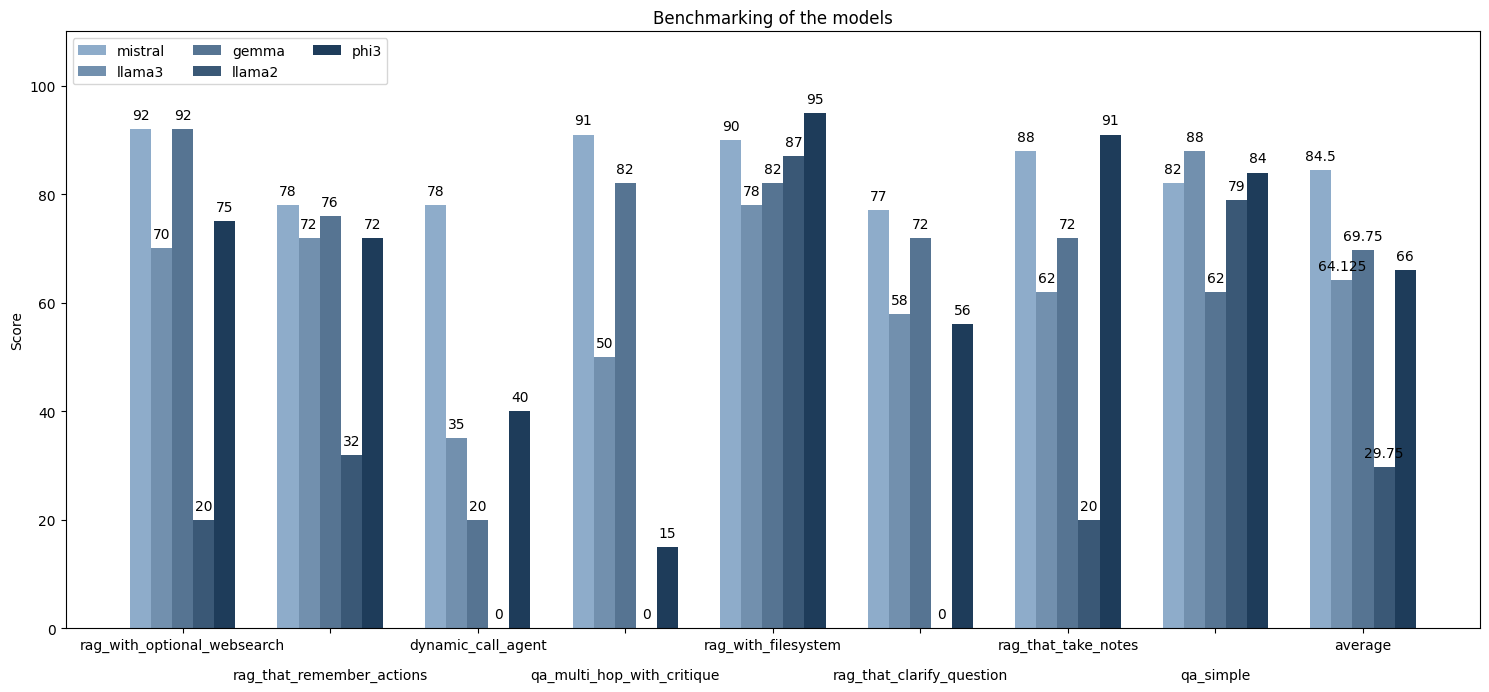

In [29]:
def showBenchmarkResults(results: pd.DataFrame):
    gap = 2
    x = np.arange(len(results.columns))
    width = 1/(len(results)+gap)
    fig, ax = plt.subplots(layout="constrained", figsize=(15, 7))
    colors = blue_color_pick(len(results))

    for multiplier, (exp_name, exp_data) in enumerate(results.iterrows()):
        offset = width * multiplier
        rects = ax.bar(x+offset, exp_data, width, label=exp_name, color=colors[multiplier])
        ax.bar_label(rects, padding=len(results))

    ax.set_ylabel("Score")
    ax.set_title("Benchmarking of the models")
    ax.set_xticks(x + width*((len(results)-1)/2), results.columns)
    ax.legend(loc='upper left', ncols=3)
    ax.set_ylim(0, 110)
    locs, labels = plt.xticks()
    for i, label in enumerate(labels):
        if i % 2 == 1:
            label.set_y(label.get_position()[1] - 0.05)

    #plt.xticks(rotation=-15)
    plt.tight_layout()
    plt.show()

showBenchmarkResults(results)

# Adding a new model assessment to benchmark comparison

In [14]:
newModelToEvaluate = "gemma"
scores = evaluate_model(newModelToEvaluate, examples, embeddings)

scores.append(np.mean(scores))
results.loc[newModelToEvaluate] = scores

EXAMPLE  rag_with_optional_websearch
 --- Step 0 ---
Call Program: main
Program Purpose: What is the tallest mountain in the world?
 --- Step 1 ---
Decision Purpose: Check if searching for information online is needed to answer the objectve's question
Decision Question: Is searching online needed to answer the objective's question?
Decision: YES
 --- Step 2 ---
Action Purpose: Perform a duckduckgo search
Action: {
  "search_query": "tallest mountain<|end|><|assistant|> Objective: Identify the tallest mountain on Earth.",
  "results": [
    {
      "title": "Is Mount Everest really the tallest mountain on Earth?",
      "href": "https://www.livescience.com/tallest-mountain-on-earth",
      "body": "Researchers have measured Mount Everest many times over the past few decades, but the latest assessment, announced in November 2021, puts it at 29,031.69 feet (8,848.86 meters) above sea level ..."
    },
    {
      "title": "Highest Mountain in the World - Tallest Mountain - Geology.com",
 

2024-05-07 10:34:16,799 ERROR dspy.primitives.assertions: 2024-05-07T08:34:16.799139Z [error    ] AssertionError: Got ENVIRONMENTAL CONSERVATION.

Selected Label should be only ONE of the following label: MAYBE or UNKNOWN or YES or NO [dspy.primitives.assertions] filename=assertions.py lineno=88
2024-05-07 10:34:16,800 ERROR dspy.evaluate.evaluate: 2024-05-07T08:34:16.800200Z [error    ] Error for example in dev set: 		 Got ENVIRONMENTAL CONSERVATION.

Selected Label should be only ONE of the following label: MAYBE or UNKNOWN or YES or NO [dspy.evaluate.evaluate] filename=evaluate.py lineno=147


EXAMPLE  rag_that_remember_actions
 --- Step 0 ---
Call Program: main
Program Purpose: Can you explain the concept of blockchain technology?
 --- Step 1 ---
Action Purpose: Search past actions to answer the objective's question
Action: {
  "query": [
    "blockchain technology explanation",
    "concept of blockchain<|end|><|assistant|> Objective: To provide a comprehensive understanding of blockchain technology."
  ],
  "past_actions": []
}
 --- Step 2 ---
Decision Purpose: Check if the answer to the objective's question is in the above search
Decision Question: Is the answer in the context?
Decision: NO
 --- Step 3 ---
Action Purpose: Perform a duckduckgo search
Action: {
  "search_query": "define blockchain technology<|end|><|assistant|> Objective: To explain the concept of blockchain technology.",
  "results": [
    {
      "title": "Blockchain, explained | MIT Sloan",
      "href": "https://mitsloan.mit.edu/ideas-made-to-matter/blockchain-explained",
      "body": "Email Address. 

2024-05-07 10:35:32,463 ERROR dspy.evaluate.evaluate: 2024-05-07T08:35:32.463704Z [error    ] Error for example in dev set: 		 https://duckduckgo.com/ return None. params=None data={'q': "Define blockchain technology<|end|><|assistant|> Objective: To provide an overview of blockchain technology, including its definition and key features.\\n\\nContext:\\n- Blockchain technology allows a network of computers to agree on the true state of a distributed ledger at regular intervals. This ledger can contain various types of shared data.\\n- CoinDesk defines blockchain as a type of ledger technology that stores and records data, emphasizing its role in cryptocurrency transactions and potential applications beyond finance.\\n\\nPast Actions:\\n1. Searched for definitions and explanations of blockchain technology using MIT Sloan's resource and CoinDesk.\\n\\nDecision: The information gathered from the past actions is sufficient to provide an overview, but a more comprehensive search could inclu

 --- Step 0 ---
Call Program: main
Program Purpose: When did the French Revolution occur?
 --- Step 1 ---
Action Purpose: Search past actions to answer the objective's question
Action: {
  "query": [
    "Date of French Revolution history events<|end|><|assistant|> Query: French Revolution timeline",
    "dates of major events in French Revolution<|end|><|assistant|> Query: French Revolution start date",
    "beginning of the French Revolution<|end|><|assistant|> Query: French Revolution years",
    "timeline of the French Revolution<|end|><|assistant|> Query: French Revolution historical dates",
    "chronology of the French Revolution<|end|><|assistant|> Query: When did the French Revolution begin?",
    "start date of the French Revolution<|end|><|assistant|> Query: French Revolution period",
    "timeframe of the French Revolution<|end|><|assistant|> Query: French Revolution occurrence year",
    "year when the French Revolution took place<|end|><|assistant|> Query: Historical date

2024-05-07 10:38:20,487 ERROR dspy.primitives.assertions: 2024-05-07T08:38:20.487633Z [error    ] AssertionError: Got BOTH<|END|><|ASSISTANT|> SELECTED LABEL: BOTH<|END|><|ASSISTANT|> OBJECTIVE: TO IDENTIFY KEY RESEARCH AREAS AND CHALLENGES IN NEURO-SYMBOLIC ARTIFICIAL INTELLIGENCE..

Selected Label should be only ONE of the following label: INSTRUCTION or QUESTION [dspy.primitives.assertions] filename=assertions.py lineno=88
2024-05-07 10:38:20,488 ERROR dspy.evaluate.evaluate: 2024-05-07T08:38:20.488623Z [error    ] Error for example in dev set: 		 Got BOTH<|END|><|ASSISTANT|> SELECTED LABEL: BOTH<|END|><|ASSISTANT|> OBJECTIVE: TO IDENTIFY KEY RESEARCH AREAS AND CHALLENGES IN NEURO-SYMBOLIC ARTIFICIAL INTELLIGENCE..

Selected Label should be only ONE of the following label: INSTRUCTION or QUESTION [dspy.evaluate.evaluate] filename=evaluate.py lineno=147


 --- Step 0 ---
Call Program: main
Program Purpose: Search for HybridAGI on internet
 --- Step 1 ---
Decision Purpose: Check if the objective is a question or an instruction
Decision Question: Choose between INSTRUCTION or QUESTION using the objective
Decision: INSTRUCTION
 --- Step 2 ---
Call Program: fulfill_objective
Program Purpose: Fullfil the objective
 --- Step 3 ---
Action Purpose: Search for existing routine to fulfill the objective
Action: {
  "query": "HybridAGI search query",
  "routines": [
    {
      "routine": "filesystem_search: Perform a similarity based search on the filesystem"
    },
    {
      "routine": "internet_search: Search the answer to the given question on internet"
    },
    {
      "routine": "read_file_to_answer: Read the given document to answer the given question"
    }
  ]
}
 --- Step 4 ---
Decision Purpose: Check if the routine to fulfill the objective is in the previous search
Decision Question: Is the routine to fulfill the objective in the abov

2024-05-07 10:40:40,769 ERROR dspy.evaluate.evaluate: 2024-05-07T08:40:40.769076Z [error    ] Error for example in dev set: 		 ('Too many retries trying to get the correct output format. Try simplifying the requirements.', {'score': "ValueError('json output should start and end with { and }')"}) [dspy.evaluate.evaluate] filename=evaluate.py lineno=147


EXAMPLE  qa_multi_hop_with_critique
 --- Step 0 ---
Call Program: main
Program Purpose: What are the risks and benefits associated with the use of AI in performance evaluation and decision-making processes within organizations?
 --- Step 1 ---
Action Purpose: Answer the objective's question
Action: {
  "answer": "The use of artificial intelligence (AI) in performance evaluation and decision-making processes presents both risks and benefits for organizations. \n\nBenefits include:\n1. Improved efficiency: AI can automate repetitive tasks, allowing employees to focus on more complex responsibilities. This leads to increased productivity and faster processing of data.\n2. Enhanced accuracy: AI algorithms are capable of analyzing large volumes of data with high precision, reducing human error in performance evaluations and decision-making processes.\n3. Data-driven insights: By leveraging machine learning techniques, organizations can uncover hidden patterns and trends within their data th

2024-05-07 10:42:42,428 ERROR dspy.primitives.assertions: 2024-05-07T08:42:42.428372Z [error    ] AssertionError: Got THE PROVIDED RESPONSE ACCURATELY ADDRESSES THE IMPACTS OF ARTIFICIAL INTELLIGENCE (AI) ON JOB MOBILITY AND GEOGRAPHIC DISTRIBUTION OF JOBS BY HIGHLIGHTING BOTH POSITIVE ASPECTS SUCH AS THE CREATION OF NEW HIGH-SKILLED POSITIONS AND INCREASED REMOTE WORK OPPORTUNITIES, AS WELL AS POTENTIAL CHALLENGES LIKE AUTOMATION LEADING TO DISPLACEMENT. TO FURTHER ENHANCE ITS ACCURACY AND DEPTH:.

Selected Label should be only ONE of the following label: NO or YES [dspy.primitives.assertions] filename=assertions.py lineno=88
2024-05-07 10:42:42,429 ERROR dspy.evaluate.evaluate: 2024-05-07T08:42:42.429517Z [error    ] Error for example in dev set: 		 Got THE PROVIDED RESPONSE ACCURATELY ADDRESSES THE IMPACTS OF ARTIFICIAL INTELLIGENCE (AI) ON JOB MOBILITY AND GEOGRAPHIC DISTRIBUTION OF JOBS BY HIGHLIGHTING BOTH POSITIVE ASPECTS SUCH AS THE CREATION OF NEW HIGH-SKILLED POSITIONS AND IN

 --- Step 0 ---
Call Program: main
Program Purpose: What are the negative implications of AI for the gig economy and freelance work?
 --- Step 1 ---
Action Purpose: Answer the objective's question
Action: {
  "answer": "The negative implications of AI on the gig economy and freelance work include job displacement as routine tasks are automated; reduced income opportunities due to increased competition from AI-powered platforms; skill obsolescence, where workers may find their skills outdated in an evolving technological landscape; and algorithmic decision-making that could lead to biased hiring processes or unfair pricing. Additionally, the widening economic disparity between those who can adapt to AI advancements and those who cannot might exacerbate existing social and economic challenges within these sectors.<|end|><|assistant|> Objective: Assess how artificial intelligence (AI) could negatively affect job security, income stability, skill development, and fair competition in the gi

2024-05-07 10:43:12,643 ERROR dspy.primitives.assertions: 2024-05-07T08:43:12.643746Z [error    ] AssertionError: Got 1. INCREASED PRODUCTIVITY THROUGH AUTOMATION.

Selected Label should be only ONE of the following label: YES or NO [dspy.primitives.assertions] filename=assertions.py lineno=88
2024-05-07 10:43:12,644 ERROR dspy.evaluate.evaluate: 2024-05-07T08:43:12.644846Z [error    ] Error for example in dev set: 		 Got 1. INCREASED PRODUCTIVITY THROUGH AUTOMATION.

Selected Label should be only ONE of the following label: YES or NO [dspy.evaluate.evaluate] filename=evaluate.py lineno=147


 --- Step 0 ---
Call Program: main
Program Purpose: What are some potential industries or professions that could be significantly affected by AI in the coming years? list 5 of them
 --- Step 1 ---
Action Purpose: Answer the objective's question
Action: {
  "answer": "1. Healthcare - AI can revolutionize diagnostics, patient care, and medical research by improving accuracy in disease detection, personalized treatment plans, and drug discovery processes.\n2. Transportation & Logistics - Autonomous vehicles, smart logistics systems, and predictive maintenance will transform the transportation industry, affecting jobs related to driving, fleet management, and supply chain operations.\n3. Manufacturing - AI-powered automation, robotics, and machine learning can optimize production processes, improve quality control, and reshape roles in manufacturing plants.\n4. Finance & Banking - AI will enhance fraud detection, risk assessment, algorithmic trading, personalized financial advice, and cust

2024-05-07 10:44:30,453 ERROR dspy.primitives.assertions: 2024-05-07T08:44:30.453314Z [error    ] AssertionError: Got 1. ADVANCED MACHINE LEARNING ALGORITHMS FOR PREDICTIVE ANALYTICS.

Selected Label should be only ONE of the following label: YES or NO [dspy.primitives.assertions] filename=assertions.py lineno=88
2024-05-07 10:44:30,454 ERROR dspy.evaluate.evaluate: 2024-05-07T08:44:30.454388Z [error    ] Error for example in dev set: 		 Got 1. ADVANCED MACHINE LEARNING ALGORITHMS FOR PREDICTIVE ANALYTICS.

Selected Label should be only ONE of the following label: YES or NO [dspy.evaluate.evaluate] filename=evaluate.py lineno=147


 --- Step 0 ---
Call Program: main
Program Purpose: How can individuals prepare themselves for a future where AI plays a more prominent role in the workforce?
 --- Step 1 ---
Action Purpose: Answer the objective's question
Action: {
  "answer": "To prepare for a future where AI plays an increasingly prominent role in the workforce, individuals should follow these steps:\n\n1. Understand AI and its impact on various industries: Stay informed about current developments in artificial intelligence technology and how it is being applied across different sectors. This can be achieved by reading industry publications, attending webinars or conferences, and following thought leaders in the field of AI.\n\n2. Identify transferable skills and those at risk of automation: Assess your current skill set to determine which abilities are likely to remain valuable even as AI becomes more prevalent. Transferable skills such as critical thinking, creativity, problem-solving, communication, and collabora

2024-05-07 10:45:38,324 ERROR dspy.primitives.assertions: 2024-05-07T08:45:38.324281Z [error    ] AssertionError: Got AI ETHICS RESEARCHER.

Selected Label should be only ONE of the following label: NO or YES [dspy.primitives.assertions] filename=assertions.py lineno=88
2024-05-07 10:45:38,325 ERROR dspy.evaluate.evaluate: 2024-05-07T08:45:38.325067Z [error    ] Error for example in dev set: 		 Got AI ETHICS RESEARCHER.

Selected Label should be only ONE of the following label: NO or YES [dspy.evaluate.evaluate] filename=evaluate.py lineno=147


EXAMPLE  rag_with_filesystem
 --- Step 0 ---
Call Program: main
Program Purpose: How does SynaLinks promote responsible AI use?
 --- Step 1 ---
Action Purpose: Search to information to answer the objective's question
Action: {
  "search_query": "SynaLinks responsible AI practices",
  "passages": []
}
 --- Step 2 ---
Action Purpose: Answer the objective's question
Action: {
  "answer": "SynaLinks promotes responsible AI use through various initiatives and programs that focus on ethical considerations, transparency, accountability, and inclusivity. Some of their key efforts include:\n\n1. Developing guidelines for responsible AI: SynaLinks has created a set of best practices and principles to guide the development and deployment of AI systems in an ethical manner. These guidelines emphasize transparency, fairness, privacy, security, and human-centric design.\n2. Collaborating with industry partners: The company works closely with other organizations, researchers, and policymakers to prom

2024-05-07 10:48:35,136 ERROR dspy.primitives.assertions: 2024-05-07T08:48:35.136250Z [error    ] AssertionError: Got "ENHANCING PERSONAL HYGIENE THROUGH EFFECTIVE HANDWASHING TECHNIQUES".

Selected Label should be only ONE of the following label: NO or YES or MAYBE [dspy.primitives.assertions] filename=assertions.py lineno=88
2024-05-07 10:48:35,137 ERROR dspy.evaluate.evaluate: 2024-05-07T08:48:35.137292Z [error    ] Error for example in dev set: 		 Got "ENHANCING PERSONAL HYGIENE THROUGH EFFECTIVE HANDWASHING TECHNIQUES".

Selected Label should be only ONE of the following label: NO or YES or MAYBE [dspy.evaluate.evaluate] filename=evaluate.py lineno=147


 --- Step 0 ---
Call Program: main
Program Purpose: When did the French Revolution occur?
 --- Step 1 ---
Call Program: clarify_objective
Program Purpose: Clarify the objective if needed
 --- Step 2 ---
Decision Purpose: Check if the objective is unclear
Decision Question: Is the objective still unclear?
Decision: NO
 --- Step 3 ---
End Program: clarify_objective
 --- Step 4 ---
Action Purpose: Answer the objective's question
Action: {
  "message": "The French Revolution started in 1789, marking a significant period of social and political upheaval in France's history.<|end|><|assistant|> Message: Hello! The French Revolution occurred from 1789 to 1799, beginning with the storming of the Bastille on July 14th, 1789. This event marked the start of a decade-long period that saw major changes in France's political landscape and had lasting impacts on European history.<|end|><|assistant|> Message: Greetings! The French Revolution took place from 1789 to 1799. It was a pivotal moment in his

2024-05-07 10:50:33,247 ERROR dspy.primitives.assertions: 2024-05-07T08:50:33.247707Z [error    ] AssertionError: Got TITLE: VERIFY LATEST USER INTERFACE UPDATE MAINTAINS FUNCTIONALITY & ENHANCES DESIGN.

Selected Label should be only ONE of the following label: YES or MAYBE or NO [dspy.primitives.assertions] filename=assertions.py lineno=88
2024-05-07 10:50:33,248 ERROR dspy.evaluate.evaluate: 2024-05-07T08:50:33.248364Z [error    ] Error for example in dev set: 		 Got TITLE: VERIFY LATEST USER INTERFACE UPDATE MAINTAINS FUNCTIONALITY & ENHANCES DESIGN.

Selected Label should be only ONE of the following label: YES or MAYBE or NO [dspy.evaluate.evaluate] filename=evaluate.py lineno=147


EXAMPLE  rag_that_take_notes
 --- Step 0 ---
Call Program: main
Program Purpose: Can you explain the concept of blockchain technology?
 --- Step 1 ---
Action Purpose: Search to documents to answer the objective's question
Action: {
  "search_query": "blockchain basics<|end|><|assistant|> Objective: Understand and explain blockchain technology.",
  "passages": [
    {
      "long_text": "Of course! Here is the content for the file `blockchain_concept.txt`:\n\nBlockchain is a distributed database that stores data in blocks linked by cryptography. It is decentralized, transparent, and tamper-proof, and can be used for various industries such as recording transactions and tracking assets in a business network.",
      "metadata": {
        "filename": "/home/user/blockchain_concept.txt"
      }
    }
  ]
}
 --- Step 2 ---
Decision Purpose: Check if the answer to the objective's question is in the above search
Decision Question: Is the answer in the context?
Decision: YES
 --- Step 3 ---
Ac

TypeError: can only concatenate str (not "int") to str

**Showing new results**

In [ ]:
showBenchmarkResults(results)